In [224]:
import pandas as pd
import numpy as np
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy import stats

In [134]:
df = pd.read_csv("Data/properatti.csv", sep = ",")

In [3]:
# 1. Completar el precio por metro cuadrado en dolares mediante el valor de precio por metro cuadrado cuando el currency es usd
# https://gitlab.com/dsdh/properatti/issues/5
#uniques = df.currency.unique()
#uniques
print("Cantidad de precios USD nulos 1: ",len(df[df.price_usd_per_m2.isnull()==True]))
# condicion dolar 'USD'
usd = 'USD'; cond_currency_usd = (df.currency == usd)
# condicion dolar 'USD'
cond_notusdprice_m2 = df.price_usd_per_m2.isnull()
# condicion price_per_m2 definido
cond_price_m2 = df.price_per_m2.notnull()
#mascara
mask_price_1 = cond_currency_usd & cond_notusdprice_m2 & cond_price_m2
df_price = df[mask_price_1 == True]

print("----Cantidad a reemplazar: ",len(df_price))
df.price_usd_per_m2.update(df_price.price_per_m2)
print("Result ==> Cantidad de precios USD nulos luego: ",len(df[df.price_usd_per_m2.isnull()==True]))

#ejemplo
df.iloc[68]

Cantidad de precios USD nulos 1:  52603
----Cantidad a reemplazar:  21437
Result ==> Cantidad de precios USD nulos luego:  31166


Unnamed: 0                                                                   68
operation                                                                  sell
property_type                                                         apartment
place_name                                                        Mar del Plata
place_with_parent_names       |Argentina|Buenos Aires Costa Atlántica|Mar de...
country_name                                                          Argentina
state_name                                         Buenos Aires Costa Atlántica
geonames_id                                                         3.43086e+06
lat-lon                                                  -38.034794,-57.5416872
lat                                                                    -38.0348
lon                                                                    -57.5417
price                                                                    235000
currency                                

In [4]:
# 2. Calcular precio por metro cuadrado a partir de superficie
# https://gitlab.com/dsdh/properatti/issues/2
print("Cantidad de precios USD nulos 2: ",len(df[df.price_usd_per_m2.isnull()==True]))
# condicion en mask1
mask1 = (df.price_usd_per_m2.isnull())& (df.surface_covered_in_m2.notnull()) & (df.price_aprox_usd.notnull())
df1 = df[mask1]

print("----Cantidad a reemplazar: ",len(df1))
# Tal vez deberia hacerse la superficie total no la cubierta
x = df1.price_aprox_usd/df1.surface_covered_in_m2
df.price_usd_per_m2.update(x)
print("Result ==> Cantidad de precios USD nulos luego: ",len(df[df.price_usd_per_m2.isnull()==True]))

#ejemplo
df.iloc[154]

Cantidad de precios USD nulos 2:  31166
----Cantidad a reemplazar:  2871
Result ==> Cantidad de precios USD nulos luego:  28295


Unnamed: 0                                                                  154
operation                                                                  sell
property_type                                                         apartment
place_name                                                             Santa Fe
place_with_parent_names                           |Argentina|Santa Fe|Santa Fe|
country_name                                                          Argentina
state_name                                                             Santa Fe
geonames_id                                                         3.83628e+06
lat-lon                                                   -31.622319,-60.705482
lat                                                                    -31.6223
lon                                                                    -60.7055
price                                                                   1.2e+06
currency                                

In [12]:
#7: Evaluamos si los tres tipos de propidad que existen son "house", "apartment" y "PH".
casas = df.loc[:,"property_type"] == "house"
print("Cantidad de casas: ",casas.sum())

apartamentos = df.loc[:,"property_type"] == "apartment"
print("Cantidad de apartamentos: ",apartamentos.sum())

ph = df.loc[:,"property_type"] == "PH"
print("Cantidad de ph: ", ph.sum())

tipopropiedad = casas & apartamentos & ph
print("Propiedad sin tipo: ",tipopropiedad.sum())


Cantidad de casas:  40268
Cantidad de apartamentos:  71065
Cantidad de ph:  5751
Propiedad sin tipo:  0


In [155]:
df.place_with_parent_names = df.place_with_parent_names.map(str.lower) #llevo a minusculas para evitar duplicados
grouped_places = df.groupby(['place_with_parent_names']) #agrupo por place_with_parent_names
dictio_places = grouped_places.groups.keys() #genero diccionario de places
cantidad_places = len(dictio_places) #cuento la cantidad de places distintos
print("Cantidad de place_with_parent_names distintos: ",cantidad_places)

count_x_places = grouped_places.agg({"operation": "count"}) #agrupo y cuento
count_x_places = count_x_places.rename(index=str, columns={"operation": "cantidad"}) #renombro la columna por cantidad
count_x_places = count_x_places.sort_values(by=['cantidad'], ascending=False) #ordeno por cantidad descendente

len(count_x_places.query("cantidad > 50")) # places con mas de <n> registros. Solo consulta


list_places = [sub_places.split('|') for sub_places in count_x_places.index]

df_places = pd.DataFrame(list_places, 
                         index = count_x_places.index, 
                         columns =['none1','pais','provincia','partido','localidad','barrio','none2']) 

    
#df_places.groupby(['none1']).count() # agrupo por primer columna para ver si hay algo. rs: no hay
#df_places.groupby(['pais']).count() # agrupo por pais para ver si algo no es argentina. rs: no hay
# agrupo por barrio para ver si hay mucha data distinta. rs: no aporta informacion. muchos vacios. ver si rellenar con API de coordenadas
#df_places.groupby(['barrio']).count()

df_places = df_places.drop(['none1', 'none2'], axis=1) # elimino none1 y none2
# Para cada columna busco vacios y asigno None
for column_name in df_places.columns:
    df_places[column_name][df_places[column_name].apply(lambda column_name: True if re.search('^\s*$', str(column_name)) else False)]=None

df_places = df_places.sort_values(by=['provincia','partido','localidad','barrio']) #ordeno
#df_places.where('provicia == capital');
df_places[(df_places.provincia == "capital federal")]

len(df_places.partido.unique())
#df_places.sample(20)

#analizar porque hay duplicados en true
#count_x_places.duplicated()





Cantidad de place_with_parent_names distintos:  1164


0

In [253]:
#q1_peso_usd_m2 = np.mean(price_usd_per_m2_arr) + 1*np.std(price_usd_per_m2_arr)
#q3_peso_usd_m2 = np.mean(price_usd_per_m2_arr) + 3*np.std(price_usd_per_m2_arr)

df_aux = df[df.price_usd_per_m2.notnull()] #elimino los nulos
q1_usd_m2, q3_usd_m2= np.percentile(df_aux.price_usd_per_m2,[25,75]) # obtengo q1 y q3
iqr_peso_usd_m2 = q3_usd_m2 - q1_usd_m2 #obtengo iqr
print("iqr:",iqr_peso_usd_m2)
print("q1:",q1_usd_m2)
print("q3:",q3_usd_m2)


left_bound = q1_usd_m2 -(1.5 * iqr_peso_usd_m2) 
right_bound = q3_usd_m2 +(1.5 * iqr_peso_usd_m2) 


#df_aux.price_usd_per_m2[(np.abs(stats.zscore(df_aux.price_usd_per_m2)) < 3).all(axis=1)]

#print(left_bound,right_bound)
right_outliers = df_aux.price_usd_per_m2[np.abs(df_aux.price_usd_per_m2) > right_bound]
#left_outliers = df_aux.price_usd_per_m2[np.abs(df_aux.price_usd_per_m2) < left_bound]
#left_outliers

#print("Valor Left:",left_bound," Cantidad de outliers:",len(left_outliers))
#print("Valor Right:",right_bound," Cantidad de outliers:",len(right_outliers))
#print(df_aux.price_usd_per_m2.describe())
df_aux = df_aux.drop(right_outliers.index)
df_aux




iqr: 1268.2299465240642
q1: 1218.1818181818182
q3: 2486.4117647058824


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
0,0,sell,PH,Mataderos,|argentina|capital federal|mataderos|,Argentina,Capital Federal,3430787.0,"-34.6618237,-58.5088387",-34.661824,...,40.0,1127.272727,1550.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bo8_venta_ph_mat...,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,https://thumbs4.properati.com/8/BluUYiHJLhgIIK...
2,2,sell,apartment,Mataderos,|argentina|capital federal|mataderos|,Argentina,Capital Federal,3430787.0,"-34.6522615,-58.5229825",-34.652262,...,55.0,1309.090909,1309.090909,NaN,NaN,NaN,http://www.properati.com.ar/15bod_venta_depart...,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,https://thumbs4.properati.com/5/SXKr34F_IwG3W_...
4,4,sell,apartment,Centro,|argentina|buenos aires costa atlántica|mar de...,Argentina,Buenos Aires Costa Atlántica,3435548.0,"-38.0026256,-57.5494468",-38.002626,...,35.0,1828.571429,1828.571429,NaN,NaN,NaN,http://www.properati.com.ar/15bok_venta_depart...,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,https://thumbs4.properati.com/5/xrRqlNcSI_vs-f...
6,6,sell,PH,Munro,|argentina|bs.as. g.b.a. zona norte|vicente ló...,Argentina,Bs.As. G.B.A. Zona Norte,3430511.0,"-34.5329567,-58.5217825",-34.532957,...,78.0,1226.415094,1666.666667,NaN,NaN,NaN,http://www.properati.com.ar/15bor_venta_ph_mun...,MUY BUEN PH AL FRENTE CON ENTRADA INDEPENDIENT...,"MUY BUEN PH AL FRENTE DOS DORMITORIOS , PATIO,...",https://thumbs4.properati.com/5/6GOXsHCyDu1aGx...
7,7,sell,apartment,Belgrano,|argentina|capital federal|belgrano|,Argentina,Capital Federal,3436077.0,"-34.5598729,-58.443362",-34.559873,...,40.0,3066.666667,3450.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bot_venta_depart...,EXCELENTE MONOAMBIENTE A ESTRENAR AMPLIO SUPER...,JOSE HERNANDEZ 1400 MONOAMBIENTE ESTRENAR CAT...,https://thumbs4.properati.com/1/IHxARynlr8sPEW...
8,8,sell,apartment,Belgrano,|argentina|capital federal|belgrano|,Argentina,Capital Federal,3436077.0,"-34.5598729,-58.443362",-34.559873,...,60.0,3000.000000,3250.000000,NaN,NaN,NaN,http://www.properati.com.ar/15bou_venta_depart...,EXCELENTE DOS AMBIENTES ESTRENAR AMPLIO SUPER...,"JOSE HERNANDEZ 1400 DOS AMBIENTES ESTRENAR ,...",https://thumbs4.properati.com/2/J3zOjgaFHrkvnv...
10,10,sell,house,Córdoba,|argentina|córdoba|córdoba|,Argentina,Córdoba,3860259.0,"-31.4200833,-64.1887761",-31.420083,...,NaN,46.235139,NaN,NaN,NaN,NaN,http://www.properati.com.ar/15boy_venta_casa_c...,"Hermosa casa sin terminar de 3 dormitorios, ba...",Casa sin terminar en Falda de Cañete. ...,https://thumbs4.properati.com/3/mQkhIxXpTTbMSc...
12,12,sell,apartment,Martínez,|argentina|bs.as. g.b.a. zona norte|san isidro...,Argentina,Bs.As. G.B.A. Zona Norte,3430813.0,"-34.4860195,-58.5038139",-34.486019,...,36.0,2948.717949,3194.444444,NaN,NaN,NaN,http://www.properati.com.ar/15bp4_venta_depart...,EXCELENTE DEPARTAMENTO 2 AMBIENTES CONTRAFRENT...,EXCELENTE DEPARTAMENTO 2 AMBIENTES CONTRAFRENT...,https://thumbs4.properati.com/6/wgSui4rTYqPncO...
13,13,sell,apartment,Palermo Soho,|argentina|capital federal|palermo|palermo soho|,Argentina,Capital Federal,3430234.0,NaN,NaN,...,30.0,2234.000000,3723.333333,NaN,1.0,NaN,http://www.properati.com.ar/15bp9_venta_depart...,Torre I Mondrian. 3 ambientes con terraza y d...,Vitraux Palermo,https://thumbs4.properati.com/2/ZTUjkRzTz6YvcU...
14,14,sell,apartment,Palermo Soho,|argentina|capital federal|palermo|palermo soho|,Argentina,Capital Federal,3430234.0,NaN,NaN,...,31.0,3521.428571,4770.967742,NaN,1.0,NaN,http://www.properati.com.ar/15bpa_venta_depart...,Torre II Dalí. Ambiente unico divisible.Vitrau...,Vitraux Palermo,https://thumbs4.properati.com/8/Uay2dC732CNlRw...


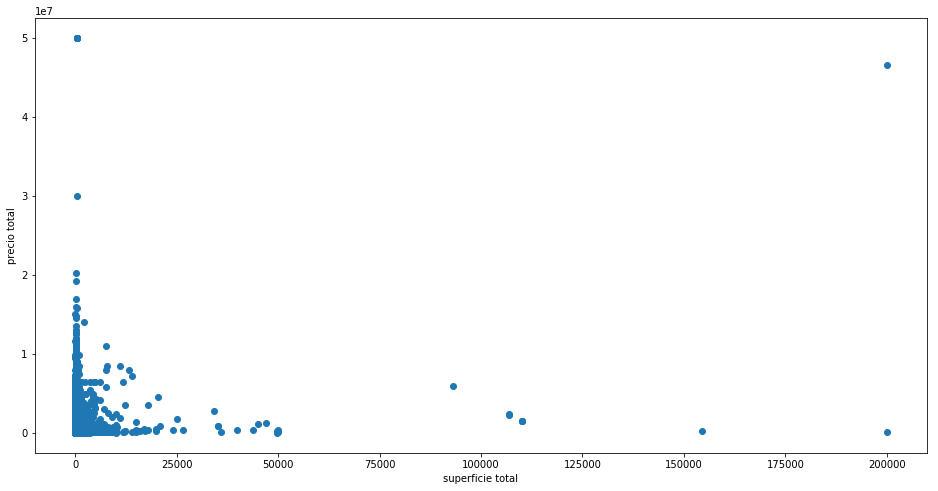

In [179]:
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df.surface_total_in_m2, df.price)
ax.set_xlabel('superficie total')
ax.set_ylabel('precio total')
plt.show()

In [ ]:
# 1
# Relacion entre precio, cantidad de 
#         habitaciones y metros cuadrados cubiertos: Para saber en que punto tiene incidencia la cantidad de habitaciones

In [ ]:
# 2
# Relacion entre cantidad de metros cubiertos y no cubiertos

In [ ]:
# 3
# Cuantos registros en price_per_m2 podemos cubrir calculando el valor 
#    total (price_aprox_usd) / metros cuadrados total (surface_total_in_m2)